In [1]:
import torch as tr
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions
from torch.nn.parameter import Parameter

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mass = -0.2
lam = 0.5
Nd =2
mtil = mass +2 *Nd 
def action(phi):
        A = 0.5*mtil*tr.einsum('bxy,bxy->b',phi,phi) + (lam/24.0)*tr.einsum('bxy,bxy->b',phi**2,phi**2)
        for mu in range(1,Nd+1):
            A = A - tr.einsum('bxy,bxy->b',phi,tr.roll(phi,shifts=-1,dims=mu))
        return A


In [3]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = tr.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = tr.nn.ModuleList([nets() for _ in range(len(masks))])
    
    # this is the forward start from noise target
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * tr.exp(s) + t)
        return x
    
    # this is backward from target to noise
    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * tr.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp #+ self.C
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        #logp = self.prior.log_prob(z)
        x = self.g(z)
        return x
    

In [4]:
L=8 # the length of the lattice which is going to be L x L torus
V=L*L # the volume

In [5]:
X = np.array(np.arange(L))[:,np.newaxis]
Y = np.array(np.arange(L))[np.newaxis,:]
#X = X[:,np.newaxis]

X = np.repeat(X,L,axis=1)
Y = np.repeat(Y,L,axis=0)
mm = (X+Y)%2
mm

array([[0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0]])

In [6]:
lm = mm.reshape(V)

In [7]:
tt = distributions.Normal(tr.zeros(V),tr.ones(V))
prior= distributions.Independent(tt, 1)
z = prior.sample((10,1)).squeeze()
z.shape
prior.log_prob(z)

tensor([-83.8705, -83.5470, -95.0971, -81.0015, -89.5354, -92.4863, -87.6796,
        -94.1103, -87.1506, -83.2454])

In [8]:
# this are functions returning nets
nets = lambda: nn.Sequential(nn.Linear(V, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, V), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(V, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, V))
# the number of masks determines layers
masks = tr.from_numpy(np.array([lm, 1-lm] * 3).astype(np.float32))
normal = distributions.Normal(tr.zeros(V),tr.ones(V))
prior= distributions.Independent(normal, 1)
flow = RealNVP(nets, nett, masks, prior)

In [25]:
batch_size = 1000
optimizer = tr.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5001):   
    #with torch.no_grad():
    z = prior.sample((batch_size, 1)).squeeze()
    x = flow.g(z) # generate a sample
    loss = (flow.log_prob(x)+action(x.view(batch_size,L,L))).mean() # KL divergence (or not?)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step() 
    if t % 500 == 0:
        #print(z.shape)
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = -25.414
iter 500: loss = -25.447
iter 1000: loss = -25.504
iter 1500: loss = -25.503
iter 2000: loss = -25.489
iter 2500: loss = -25.488
iter 3000: loss = -25.526
iter 3500: loss = -25.583
iter 4000: loss = -25.559
iter 4500: loss = -25.569
iter 5000: loss = -25.591


In [26]:
z = prior.sample((batch_size, 1)).squeeze()
x = flow.g(z)
x.shape
x,j = flow.f(z)
prior.log_prob(z).shape,j.shape

(torch.Size([1000]), torch.Size([1000]))

In [27]:
z = prior.sample((10, 1)).squeeze()
x = flow.g(z)

In [28]:
zz,j=flow.f(x)

In [29]:
print(zz.requires_grad,z.requires_grad)

True False


In [30]:
print(tr.sum(tr.abs(zz-z))/V)

tensor(2.0460e-06, grad_fn=<DivBackward0>)


In [31]:
diff = action(x.view(x.shape[0],L,L))+flow.log_prob(x)
print(diff)

tensor([-24.7596, -24.4981, -25.6951, -25.8526, -26.2686, -25.2709, -26.2369,
        -25.1544, -25.1908, -22.9200], grad_fn=<AddBackward0>)


In [32]:
print(diff - diff.mean())

tensor([ 0.4251,  0.6866, -0.5104, -0.6679, -1.0839, -0.0862, -1.0522,  0.0303,
        -0.0061,  2.2647], grad_fn=<SubBackward0>)


In [33]:
z = prior.sample((2000, 1)).squeeze()
xz = flow.g(z).detach()
diff = action(xz.view(xz.shape[0],L,L))+flow.log_prob(xz)
diff.std()

tensor(0.6328, grad_fn=<StdBackward0>)

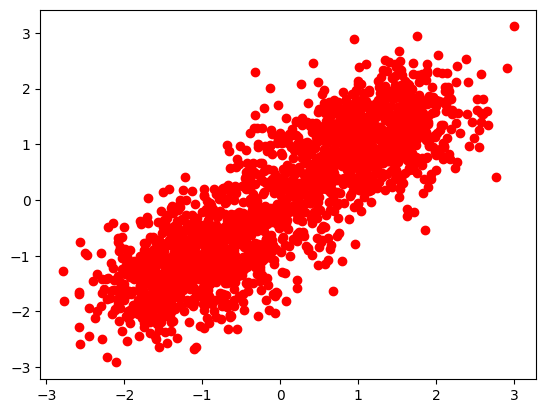

In [34]:
x = flow.sample(2000).detach().numpy()
plt.scatter(x[:, 0,0], x[:, 0,1], c='r')